In [1]:
from fastai.tabular.all import *
from transfertab.utils import *
from transfertab.transfer import *
from transfertab.extract import *
from fastcore.xtras import *
from fastai.learner import *
import torch
import numpy as np
from fastai.interpret import *

In [2]:
import pandas as pd
df = pd.read_csv("../data/bank-additional-full.csv", delimiter=';')

In [3]:
import wandb
from fastai.callback.wandb import *

In [4]:
df.shape

(41188, 21)

In [5]:
41188 * 0.7

28831.6

In [6]:
dfA = df.iloc[0:28831]
dfB = df.iloc[28831:-1]

In [7]:
dfA.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [8]:
contcols = ['age', 'duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']
catcols = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 
	'month', 'day_of_week','poutcome']
target = 'y'

In [10]:
splitsA = RandomSplitter(valid_pct=0.2)(range_of(dfA))
toA = TabularPandas(dfA, procs=[Categorify, FillMissing, Normalize],
                   cat_names=catcols,
                   cont_names=contcols,
                   y_names=target,
                   splits=splitsA)
dlsA = toA.dataloaders(bs=512)
rocaucbin = RocAucBinary()
learnA = tabular_learner(dlsA, metrics=[rocaucbin, accuracy])

In [11]:
wandb.init(
    project='Experiments', 
    save_code=True, 
    group='Exp4c v2', 
    job_type='pretrain', 
    tags=['base', 'bank', 'modelA'], 
    name='modelA training',
    notes="Training modelA from which we'll take embeddings",
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/results/exp4c-v2',
    entity='transfertab'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: manikya (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [12]:
cbs=[WandbCallback(log="all", dataset_name="bank-additional-full (first .7)", n_preds=128, seed=1), SaveModelCallback()]
learnA.fit_one_cycle(50, cbs=cbs)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.742446,0.676085,0.901483,0.733611,00:02
1,0.721670,0.685274,0.940751,0.802116,00:06
2,0.700482,0.660726,0.936917,0.869754,00:06
3,0.671983,0.615222,0.950835,0.888831,00:06
4,0.625605,0.543329,0.952714,0.899063,00:06
5,0.546002,0.425536,0.925603,0.936178,00:06
6,0.422753,0.281234,0.918322,0.945023,00:10
7,0.302040,0.196519,0.888314,0.947451,00:06
8,0.214999,0.146657,0.934127,0.947797,00:06
9,0.166288,0.127942,0.949302,0.947971,00:06


Better model found at epoch 0 with valid_loss value: 0.6760854125022888.
Better model found at epoch 2 with valid_loss value: 0.6607264280319214.
Better model found at epoch 3 with valid_loss value: 0.6152218580245972.
Better model found at epoch 4 with valid_loss value: 0.5433291792869568.
Better model found at epoch 5 with valid_loss value: 0.42553603649139404.
Better model found at epoch 6 with valid_loss value: 0.2812340259552002.
Better model found at epoch 7 with valid_loss value: 0.19651906192302704.
Better model found at epoch 8 with valid_loss value: 0.14665652811527252.
Better model found at epoch 9 with valid_loss value: 0.1279415786266327.
Better model found at epoch 11 with valid_loss value: 0.12322241067886353.
Better model found at epoch 14 with valid_loss value: 0.1194349154829979.


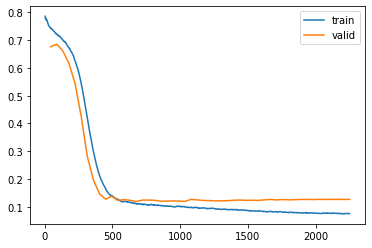

In [13]:
learnA.recorder.plot_loss()

In [16]:
torch.save(learnA.model.state_dict(),"../results/exp4c-v2/modelA_state_dict")

In [52]:
catdictA = {col:list(learnA.dls.categorify.classes[col]) for col in catcols}

In [18]:
embeds = extractembeds(learnA.model, catdictA, transfercats=catcols, allcats=catcols, path="learnA_extracts", kind="json")

In [19]:
wandb.finish()

epoch,50
train_loss,0.07568
raw_loss,0.07273
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_runtime,366
_timestamp,1635736447
_step,2249


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,███▇▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,███▇▅▄▃▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [83]:
splitsB = RandomSplitter(valid_pct=0.2)(range_of(dfB))
toB = TabularPandas(dfB, procs=[Categorify, FillMissing, Normalize],
                   cat_names = catcols,
                   cont_names = contcols,
                   y_names=target,
                   splits=splitsB)
dlsB = toB.dataloaders(bs=512)

In [84]:
rocaucbinB = RocAucBinary()
learnB = tabular_learner(dlsB, metrics=[rocaucbinB, accuracy], emb_szs={'month':6})

In [85]:
# catdict = getcatdict(df, catcols)
# metadict = {}
# for (cat, classes) in catdict.items():
# 	metadict[cat] = {'mapped_cat': cat, 'classes_info': {clas: clas for clas in classes}}
# with open('bank_meta.json', 'w') as fp:
# 	json.dump(metadict, fp)

In [86]:
# metadict={"job": {"mapped_cat": "job", "classes_info": {"#na#": "#na#", "admin.": "admin.", "blue-collar": "blue-collar", "entrepreneur": "entrepreneur", "housemaid": "housemaid", "management": "management", "retired": "retired", "self-employed": "self-employed", "services": "services", "student": "student", "technician": "technician", "unemployed": "unemployed", "unknown": "unknown"}}, "marital": {"mapped_cat": "marital", "classes_info": {"#na#": "#na#", "divorced": "divorced", "married": "married", "single": "single", "unknown": "unknown"}}, "education": {"mapped_cat": "education", "classes_info": {"#na#": "#na#", "basic.4y": "basic.4y", "basic.6y": "basic.6y", "basic.9y": "basic.9y", "high.school": "high.school", "illiterate": "illiterate", "professional.course": "professional.course", "university.degree": "university.degree", "unknown": "unknown"}}, "default": {"mapped_cat": "default", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown"}}, "housing": {"mapped_cat": "housing", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "loan": {"mapped_cat": "loan", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "contact": {"mapped_cat": "contact", "classes_info": {"#na#": "#na#", "cellular": "cellular", "telephone": "telephone"}}, "month": {"mapped_cat": "month", "classes_info": {"#na#": "#na#", "apr": "apr", "aug": "aug", "dec": "dec", "jul": "jul", "jun": "jun", "mar": "mar", "may": "may", "nov": "nov", "oct": "oct", "sep":[]}}, "day_of_week": {"mapped_cat": "day_of_week", "classes_info": {"#na#": "#na#", "fri": "fri", "mon": "mon", "thu": "thu", "tue": "tue", "wed": "wed"}}, "poutcome": {"mapped_cat": "poutcome", "classes_info": {"#na#": "#na#", "failure": "failure", "nonexistent": "nonexistent", "success": "success"}}}

In [87]:
with open('../data/jsons/bank_meta.json', 'r') as fp:
    metadict = json.load(fp) 

In [88]:
metadict

{'job': {'mapped_cat': 'job',
  'classes_info': {'#na#': '#na#',
   'admin.': 'admin.',
   'blue-collar': 'blue-collar',
   'entrepreneur': 'entrepreneur',
   'housemaid': 'housemaid',
   'management': 'management',
   'retired': 'retired',
   'self-employed': 'self-employed',
   'services': 'services',
   'student': 'student',
   'technician': 'technician',
   'unemployed': 'unemployed',
   'unknown': 'unknown'}},
 'marital': {'mapped_cat': 'marital',
  'classes_info': {'#na#': '#na#',
   'divorced': 'divorced',
   'married': 'married',
   'single': 'single',
   'unknown': 'unknown'}},
 'education': {'mapped_cat': 'education',
  'classes_info': {'#na#': '#na#',
   'basic.4y': 'basic.4y',
   'basic.6y': 'basic.6y',
   'basic.9y': 'basic.9y',
   'high.school': 'high.school',
   'illiterate': 'illiterate',
   'professional.course': 'professional.course',
   'university.degree': 'university.degree',
   'unknown': 'unknown'}},
 'default': {'mapped_cat': 'default',
  'classes_info': {'#na#'

In [89]:
learnB.dls.categorify['default']

['#na#', 'no', 'unknown']

In [90]:
learnA.dls.categorify['default']

['#na#', 'no', 'unknown', 'yes']

In [91]:
learnA.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(4, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(10, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [92]:
learnB.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(3, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(11, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [93]:
learnB.dls.cat_names

(#10) ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

In [94]:
transfercats = ['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [95]:
catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcols}

In [96]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdictA, 
    newcatdict=catdictB)

In [97]:
learnA.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [98]:
learnB.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [99]:
dlsC = deepcopy(dlsB)
rocaucbinC = RocAucBinary()
learnC = tabular_learner(dlsC, metrics=[rocaucbinC, accuracy], emb_szs={'month':6})

In [100]:
learnC.model.layers.load_state_dict(learnB.model.layers.state_dict())

<All keys matched successfully>

In [82]:
wandb.init(
    project='Experiments',
    entity='transfertab',
    save_code=True, 
    group='Exp4c v2', 
    job_type='finetune', 
    tags=['transfer', 'bank', 'modelB'], 
    name='modelB training',
    notes='Training modelB which contains transferred embeddings',
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/results/exp4c-v2'
)

wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [101]:
for i in range(len(catcols)):
    learnB.model.embeds[i].weight.requires_grad = False
learnB.create_opt()

In [102]:
learnB.embeds[5].weight

Parameter containing:
tensor([[ 0.0012, -0.0142, -0.0104],
        [-0.0150,  0.0564, -0.0425],
        [-0.0274,  0.0058, -0.0065],
        [ 0.0386, -0.0425,  0.0627]])

In [103]:
cbsB=[WandbCallback(log="all", dataset_name="bank 0.3%", n_preds=128, seed=1)]
learnB.fit_one_cycle(3, cbs=cbsB)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.583056,0.652738,0.870181,0.725212,00:00
1,0.531010,0.522188,0.885025,0.811817,00:06
2,0.501736,0.498829,0.885407,0.809389,00:07


In [104]:
for i in range(len(catcols)):
    learnB.model.embeds[i].weight.requires_grad = True
learnB.create_opt()

In [105]:
learnB.fit_one_cycle(5, cbs=cbsB)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.461604,0.481070,0.882981,0.804533,00:00
1,0.449091,0.459576,0.882086,0.808580,00:07
2,0.429367,0.434223,0.885819,0.820316,00:06
3,0.409259,0.421703,0.887061,0.815864,00:06
4,0.394413,0.422471,0.887898,0.817887,00:06


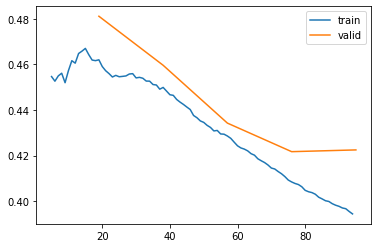

In [106]:
learnB.recorder.plot_loss()

In [107]:
wandb.finish()

epoch,8
train_loss,0.39441
raw_loss,0.34937
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.94995
eps_0,1e-05
_runtime,115
_timestamp,1635738231
_step,152


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▇▇▆▆▅▅▅▅▄▄▄▄▄▂▂▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
raw_loss,██▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▄▃▃▂▄▄▃▃▂▂▂▂▃▂▂▁▁▁▂▂▁▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▅▇██▇▇▆▅▄▃▂▁▁▁▂▃▅▆█████▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁
mom_0,█▇▅▂▁▁▂▂▃▄▅▆▇████▆▄▃▁▁▁▁▁▂▂▃▃▄▄▅▆▆▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [108]:
wandb.init(
    project='Experiments',
    entity='transfertab',
    save_code=True, 
    group='Exp4c v2', 
    job_type='controlgrp',
    tags=['base', 'bank', 'modelC'], 
    name='modelC training',
    notes='Training modelC which contains randomly initialized weights and same classifier weights as modelB',
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/results/exp4c-v2'
)

wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [109]:
cbsC=[WandbCallback(log="all", dataset_name="bank 0.3%", n_preds=128, seed=1)]
learnC.fit_one_cycle(8, cbs=cbsC)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07
7,0.406062,0.427293,0.889090,0.821934,00:06


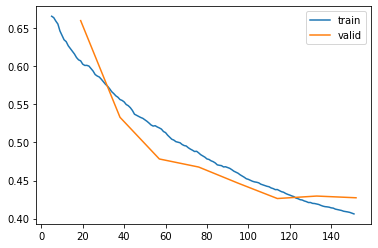

In [110]:
learnC.recorder.plot_loss()

In [111]:
wandb.finish()

epoch,8
train_loss,0.40606
raw_loss,0.35641
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.94998
eps_0,1e-05
_runtime,67
_timestamp,1635738409
_step,151


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
raw_loss,██▇▆▆▆▆▅▄▄▅▄▄▄▃▄▂▃▃▃▂▃▂▄▂▂▂▃▂▂▂▂▁▂▂▁▂▂▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇███████▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▆▄▃▂▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [112]:
torch.save(learnB.model.state_dict(),"../results/exp4c-v2/modelB_state_dict")
torch.save(learnC.model.state_dict(),"../results/exp4c-v2/modelC_state_dict")

In [113]:
learnB.model.state_dict()

OrderedDict([('embeds.0.weight',
              tensor([[ 0.0028, -0.0037,  0.0106, -0.0079,  0.0066, -0.0125, -0.0009],
                      [-0.0748, -0.0353, -0.0279, -0.0419,  0.0048,  0.1019,  0.0367],
                      [ 0.0337,  0.0332, -0.0002,  0.0111,  0.0184,  0.0006,  0.0317],
                      [ 0.0064,  0.0925,  0.0245,  0.0144, -0.0080, -0.0071, -0.0284],
                      [ 0.0931, -0.0545,  0.1390, -0.0037, -0.0719, -0.0115, -0.0150],
                      [-0.0386,  0.0412, -0.0634,  0.0064,  0.0619,  0.0253, -0.0042],
                      [-0.0381, -0.0761, -0.0039, -0.0610,  0.0093, -0.0381,  0.0322],
                      [ 0.0848, -0.0294,  0.0395,  0.0607, -0.0904, -0.0394,  0.1236],
                      [ 0.0060,  0.0425, -0.0086,  0.0106,  0.0148,  0.0493, -0.0118],
                      [-0.0169, -0.0866,  0.0317, -0.0122,  0.0251, -0.1155,  0.0106],
                      [ 0.0598, -0.0023,  0.0174,  0.0342, -0.0088, -0.0320, -0.0730],
          

In [114]:
learnC.model.state_dict()

OrderedDict([('embeds.0.weight',
              tensor([[-0.0020, -0.0050, -0.0009,  0.0097, -0.0045, -0.0065,  0.0064],
                      [-0.0126, -0.0143,  0.0184, -0.0268,  0.0166,  0.0199, -0.0203],
                      [ 0.0253,  0.0199, -0.0130,  0.0154, -0.0054,  0.0262,  0.0028],
                      [-0.0205, -0.0126, -0.0010, -0.0073, -0.0068, -0.0157,  0.0137],
                      [-0.0293, -0.0056,  0.0032, -0.0134,  0.0119, -0.0157, -0.0048],
                      [ 0.0328,  0.0149, -0.0210, -0.0082, -0.0009,  0.0093,  0.0015],
                      [-0.0201,  0.0226, -0.0007, -0.0049, -0.0081,  0.0021, -0.0120],
                      [ 0.0216,  0.0103, -0.0190,  0.0204,  0.0037, -0.0207, -0.0171],
                      [ 0.0220, -0.0270, -0.0241, -0.0035, -0.0119,  0.0320, -0.0027],
                      [-0.0072,  0.0082,  0.0130, -0.0012, -0.0106, -0.0186,  0.0101],
                      [ 0.0078,  0.0171,  0.0352,  0.0367,  0.0096, -0.0509,  0.0156],
          